In [34]:
from unittest import TestLoader
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [35]:
import os
checkpoints = 'checkpoints'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [37]:
def get_bird_data(augmentation=0):
    transforms_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding = 8, padding_mode='edge'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='birds/train', transform=transforms_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open('birds/names.txt').read().strip().split('\n')
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k, v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name': idx_to_name}

In [38]:
data = get_bird_data()

In [39]:
print(len(data['to_name']))
print(data['to_class'])
print(data['to_name'])

555
{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199,

torch.Size([8, 3, 128, 128])


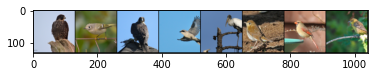

Labels:Peregrine Falcon (Immature), Ruby-crowned Kinglet, Peregrine Falcon (Immature), Loggerhead Shrike, Wood Stork,     Veery, Northern Cardinal (Female/Juvenile), Orchard Oriole (Female/Juvenile)


In [40]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('Labels:' + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [52]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [53]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555) # This will reinitialize the layer as well

Using cache found in C:\Users\vicjo/.cache\torch\hub\pytorch_vision_v0.6.0


In [54]:
losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=10, checkpoint_path=checkpoints)

[0,    10] loss: 6.565
[0,    20] loss: 6.379
[0,    30] loss: 6.204
[0,    40] loss: 5.949
[0,    50] loss: 5.714
[0,    60] loss: 5.482
[0,    70] loss: 5.186
[0,    80] loss: 5.101
[0,    90] loss: 4.852
[0,   100] loss: 4.701
[0,   110] loss: 4.469
[0,   120] loss: 4.317
[0,   130] loss: 4.223
[0,   140] loss: 4.146
[0,   150] loss: 3.973
[0,   160] loss: 3.883
[0,   170] loss: 3.729
[0,   180] loss: 3.699
[0,   190] loss: 3.579
[0,   200] loss: 3.466
[0,   210] loss: 3.423
[0,   220] loss: 3.309
